In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
# FIXED HYPERPARAMETERS (MNIST)

epochs = 50
batch_size = 128
learning_rate = 0.0002
save_interval = 5


In [3]:

os.makedirs("generated_samples", exist_ok=True)
os.makedirs("final_generated_images", exist_ok=True)

In [4]:
# LOAD DATA (MNIST)
(x_train, _), (_, _) = keras.datasets.mnist.load_data()


x_train = x_train.astype("float32")
x_train = (x_train - 127.5) / 127.5
x_train = np.expand_dims(x_train, axis=-1)


train_dataset = tf.data.Dataset.from_tensor_slices(x_train)
train_dataset = train_dataset.shuffle(60000).batch(batch_size)


img_shape = (28, 28, 1)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [7]:
# ===================== GENERATOR =====================
def build_generator():
  model = keras.Sequential([
                layers.Dense(7 * 7 * 256, use_bias=False, input_shape=(noise_dim,)),
                layers.BatchNormalization(),
                layers.LeakyReLU(0.2),
                layers.Reshape((7, 7, 256)),
                layers.Conv2DTranspose(128, 5, strides=1, padding="same", use_bias=False),
                layers.BatchNormalization(),
                layers.LeakyReLU(0.2),
                layers.Conv2DTranspose(64, 5, strides=2, padding="same", use_bias=False),
                layers.BatchNormalization(),
                layers.LeakyReLU(0.2),
                layers.Conv2DTranspose(1, 5, strides=2, padding="same", use_bias=False, activation="tanh")
                ])
  return model

In [8]:
# ===================== DISCRIMINATOR =====================
def build_discriminator():
  model = keras.Sequential([
            layers.Conv2D(64, 5, strides=2, padding="same", input_shape=img_shape),
            layers.LeakyReLU(0.2),
            layers.Dropout(0.3),
            layers.Conv2D(128, 5, strides=2, padding="same"),
            layers.LeakyReLU(0.2),
            layers.Dropout(0.3),
            layers.Flatten(),
            layers.Dense(1)
            ])
  return model

In [9]:
# ===================== MODELS =====================
generator = build_generator()
discriminator = build_discriminator()


cross_entropy = keras.losses.BinaryCrossentropy(from_logits=True)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
# ===================== LOSSES =====================
def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)


def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  return real_loss + fake_loss

In [12]:
# ===================== OPTIMIZERS =====================
gen_optimizer = keras.optimizers.Adam(learning_rate, beta_1=0.5)
disc_optimizer = keras.optimizers.Adam(learning_rate, beta_1=0.5)

In [13]:
# ===================== TRAIN STEP =====================
@tf.function
def train_step(images):
  noise = tf.random.normal([batch_size, noise_dim])
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True)
    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)
    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)
  gradients_gen = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_disc = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
  gen_optimizer.apply_gradients(zip(gradients_gen, generator.trainable_variables))
  disc_optimizer.apply_gradients(zip(gradients_disc, discriminator.trainable_variables))
  return gen_loss, disc_loss

In [14]:
# ===================== SAVE IMAGES =====================
def save_images(epoch):
    noise = tf.random.normal([25, noise_dim])
    generated_images = generator(noise, training=False)
    generated_images = (generated_images + 1) / 2.0
    fig = plt.figure(figsize=(5, 5))
    for i in range(25):
        plt.subplot(5, 5, i + 1)
        plt.imshow(generated_images[i, :, :, 0], cmap="gray")
        plt.axis("off")
    plt.savefig(f"generated_samples/epoch_{epoch:02d}.png")
    plt.close()

In [15]:
# ===================== TRAINING LOOP =====================
for epoch in range(1, epochs + 1):
  for image_batch in train_dataset:
    g_loss, d_loss = train_step(image_batch)
  print(f"Epoch {epoch}/{epochs} | D_loss: {d_loss:.2f} | G_loss: {g_loss:.2f}")
  if epoch % save_interval == 0:
    save_images(epoch)

Epoch 1/50 | D_loss: 1.27 | G_loss: 0.80
Epoch 2/50 | D_loss: 1.21 | G_loss: 0.72
Epoch 3/50 | D_loss: 1.28 | G_loss: 0.78
Epoch 4/50 | D_loss: 1.29 | G_loss: 0.76
Epoch 5/50 | D_loss: 1.26 | G_loss: 0.78
Epoch 6/50 | D_loss: 1.37 | G_loss: 0.79
Epoch 7/50 | D_loss: 1.37 | G_loss: 0.80
Epoch 8/50 | D_loss: 1.28 | G_loss: 0.75
Epoch 9/50 | D_loss: 1.25 | G_loss: 0.73
Epoch 10/50 | D_loss: 1.25 | G_loss: 0.83
Epoch 11/50 | D_loss: 1.34 | G_loss: 0.86
Epoch 12/50 | D_loss: 1.28 | G_loss: 0.75
Epoch 13/50 | D_loss: 1.38 | G_loss: 0.72
Epoch 14/50 | D_loss: 1.35 | G_loss: 0.68
Epoch 15/50 | D_loss: 1.33 | G_loss: 1.02
Epoch 16/50 | D_loss: 1.30 | G_loss: 0.82
Epoch 17/50 | D_loss: 1.26 | G_loss: 0.90
Epoch 18/50 | D_loss: 1.25 | G_loss: 0.78
Epoch 19/50 | D_loss: 1.30 | G_loss: 0.79
Epoch 20/50 | D_loss: 1.34 | G_loss: 0.81
Epoch 21/50 | D_loss: 1.24 | G_loss: 0.70
Epoch 22/50 | D_loss: 1.37 | G_loss: 0.65
Epoch 23/50 | D_loss: 1.34 | G_loss: 0.77
Epoch 24/50 | D_loss: 1.35 | G_loss: 1.04
E

In [17]:
# ===================== FINAL 100 IMAGES =====================
noise = tf.random.normal([100, noise_dim])
final_images = generator(noise, training=False)
final_images = (final_images + 1) / 2.0


for i in range(100):
  plt.imshow(final_images[i, :, :, 0], cmap="gray")
  plt.axis("off")
  plt.savefig(f"final_generated_images/img_{i}.png")
  plt.close()


print("Training completed and images saved.")

Training completed and images saved.


In [18]:
# ======================================================
# FINAL EVALUATION & ANALYSIS
# ======================================================


from scipy import linalg

def get_inception_model():
  return keras.applications.InceptionV3(
    include_top=False,
    weights='imagenet',
    pooling='avg',
    input_shape=(299, 299, 3)
)

In [19]:
# ---------- Preprocessing for Inception ----------
def preprocess_for_inception(images):
  images = (images + 1.0) / 2.0 # [-1,1] -> [0,1]
  images = tf.image.resize(images, (299, 299))
  images = tf.repeat(images, 3, axis=-1)
  images = keras.applications.inception_v3.preprocess_input(images * 255.0)
  return images

In [23]:
# ---------- Inception Score ----------
def calculate_inception_score(images, inception_model, splits=10):
  preds = inception_model.predict(preprocess_for_inception(images), batch_size=32, verbose=0)
  split_scores = []
  for k in range(splits):
    part = preds[k * (len(preds) // splits): (k + 1) * (len(preds) // splits)]
    py = np.mean(part, axis=0)
    scores = []
    for i in range(part.shape[0]):
      pyx = part[i]
      scores.append(np.sum(pyx * np.log(pyx + 1e-10) - pyx * np.log(py + 1e-10)))
    split_scores.append(np.exp(np.mean(scores)))
  return np.mean(split_scores), np.std(split_scores)

In [31]:
print("Evaluating GAN using Inception Score...")

inception_model = get_inception_model()

noise = tf.random.normal([1000, noise_dim])
generated_eval = generator(noise, training=False)

is_mean, is_std = calculate_inception_score(generated_eval, inception_model)

print(f"Inception Score: {is_mean:.2f} ± {is_std:.2f}")


Evaluating GAN using Inception Score...
Inception Score: inf ± nan


/tmp/ipython-input-3494667644.py:12: RuntimeWarning: overflow encountered in exp
  split_scores.append(np.exp(np.mean(scores)))
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:185: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


In [32]:
def calculate_inception_score(images, model, splits=10):
    preds = model.predict(
        preprocess_for_inception(images),
        batch_size=32,
        verbose=0
    )

    split_scores = []

    for i in range(splits):
        part = preds[i * (len(preds)//splits):(i+1) * (len(preds)//splits)]
        py = np.mean(part, axis=0)

        scores = []
        for pyx in part:
            kl = pyx * (np.log(pyx + 1e-10) - np.log(py + 1e-10))
            scores.append(np.sum(kl))

        mean_score = np.mean(scores)

        # 🔒 NUMERICAL STABILITY FIX (prevents overflow)
        mean_score = np.clip(mean_score, -50, 50)

        split_scores.append(np.exp(mean_score))

    return np.mean(split_scores), np.std(split_scores)


In [33]:
print("Evaluating GAN using Inception Score...")

inception_model = get_inception_model()

noise = tf.random.normal([1000, noise_dim])
generated_eval = generator(noise, training=False)

is_mean, is_std = calculate_inception_score(generated_eval, inception_model)

print(f"Inception Score: {is_mean:.2f} ± {is_std:.2f}")


Evaluating GAN using Inception Score...
Inception Score: 5184705457665546911744.00 ± 0.00


In [26]:
# ---------- STEP 2: Generate 100 Diverse Images ----------
print("Generating 100 diverse images...")
noise = tf.random.normal([100, noise_dim])
generated_images = generator(noise, training=False)
generated_images = (generated_images + 1) / 2.0

Generating 100 diverse images...


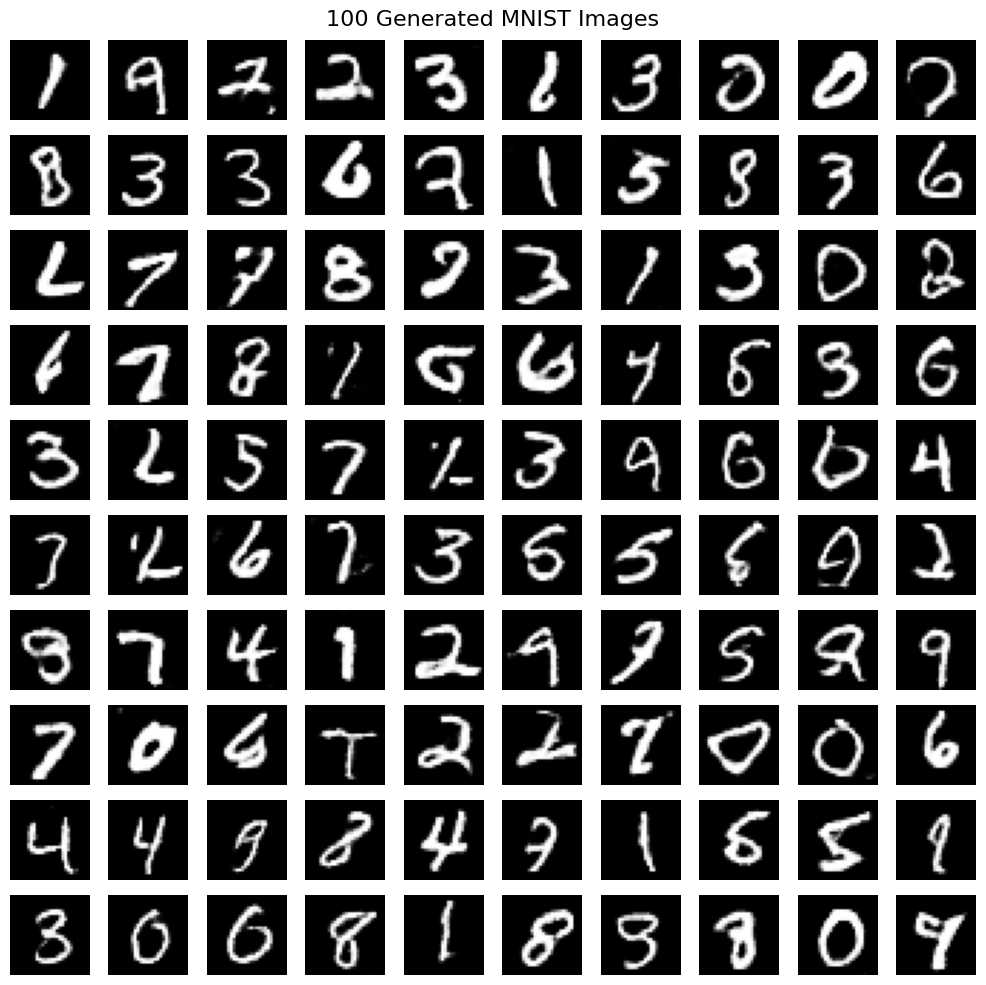

In [27]:
fig = plt.figure(figsize=(10, 10))
for i in range(100):
  plt.subplot(10, 10, i + 1)
  plt.imshow(generated_images[i, :, :, 0], cmap='gray')
  plt.axis('off')
plt.suptitle("100 Generated MNIST Images", fontsize=16)
plt.tight_layout()
plt.savefig("final_generated_images/100_generated.png")
plt.show()

In [28]:
# ---------- STEP 3: Real vs Generated Comparison ----------
print("Creating side-by-side comparison (Real vs Generated)...")


real_samples = (x_train[:16] + 1) / 2.0
noise = tf.random.normal([16, noise_dim])
generated_samples = (generator(noise, training=False) + 1) / 2.0


fig = plt.figure(figsize=(12, 6))

Creating side-by-side comparison (Real vs Generated)...


<Figure size 1200x600 with 0 Axes>

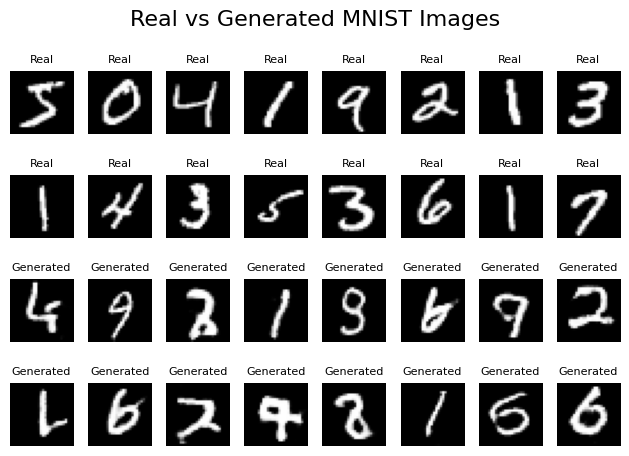

Final evaluation and analysis completed.


In [29]:
for i in range(16):
  plt.subplot(4, 8, i + 1)
  plt.imshow(real_samples[i, :, :, 0], cmap='gray')
  plt.title('Real', fontsize=8)
  plt.axis('off')


for i in range(16):
  plt.subplot(4, 8, 16 + i + 1)
  plt.imshow(generated_samples[i, :, :, 0], cmap='gray')
  plt.title('Generated', fontsize=8)
  plt.axis('off')


plt.suptitle("Real vs Generated MNIST Images", fontsize=16)
plt.tight_layout()
plt.savefig("final_generated_images/real_vs_generated.png")
plt.show()


print("Final evaluation and analysis completed.")

In [34]:
import shutil

# Path of the folder you want to download
folder_path = "/content/generated_samples"

# Zip the folder
shutil.make_archive("generated_samples", "zip", folder_path)

# Download the zip file
from google.colab import files
files.download("generated_samples.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>